In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dropout





# **Exploratory Data Analysis (EDA)**

In [27]:
# Load the dataset
file_path = 'cleaned_electricity_data.csv'
df = pd.read_csv(file_path)
print(df.head())

                            CONS_NO  FLAG  2014/1/1  2014/1/10  2014/1/11  \
0  0387DD8A07E07FDA6271170F86AD9151     1       0.0       0.00       0.00   
1  01D6177B5D4FFE0CABA9EF17DAFC2B84     1       0.0       0.00       0.00   
2  4B75AC4F2D8434CFF62DB64D0BB43103     1       0.0       0.00       0.00   
3  B32AC8CC6D5D805AC053557AB05F5343     1       0.0       0.00       0.00   
4  EDFC78B07BA2908B3395C4EB2304665E     1       2.9       3.42       3.81   

   2014/1/12  2014/1/13  2014/1/14  2014/1/15  2014/1/16  ...  2016/9/29  \
0       0.00       0.00       0.00       0.00       0.00  ...       9.96   
1       0.00       0.00       0.00       0.00       0.00  ...       0.00   
2       0.00       0.00       0.00       0.00       0.00  ...       0.00   
3       0.00       0.00       0.00       0.00       0.00  ...       9.99   
4       4.58       3.56       4.25       3.86       3.53  ...      10.37   

   2016/9/3  2016/9/30  2016/9/4  2016/9/5  2016/9/6  2016/9/7  2016/9/8  \
0   

# **Preprocessing**

In [28]:
# Separate features and labels
X = df.iloc[:, 2:-1]  # all columns except the 'FLAG' and 'CONSUMER_ID'
y = df['FLAG']        # the anomaly flag column


In [29]:
from sklearn.model_selection import train_test_split

# Split the original data into LSTM and Random Forest datasets
X_lstm, X_rf, y_lstm, y_rf = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)


Split the data for training lstm model and testing on the random forest classifier.

In [30]:
# smote_lstm = SMOTE(random_state=42)
# X_lstm_balanced, y_lstm_balanced = smote_lstm.fit_resample(X_lstm, y_lstm)

# Normalize data
scaler = MinMaxScaler()
X_lstm_scaled = scaler.fit_transform(X_lstm)

# Apply PCA
pca = PCA(n_components=100)
X_lstm_reduced = pca.fit_transform(X_lstm_scaled)

# Verify PCA explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print("Explained Variance by 100 components:", explained_variance)
if explained_variance < 0.9:
    print(f"Warning: PCA retains only {explained_variance:.2%} of the variance. Consider increasing n_components.")

# Generate sequences for LSTM
time_steps = 30
X_lstm_sequences = np.array([X_lstm_reduced[i - time_steps:i, :] for i in range(time_steps, X_lstm_reduced.shape[0])])
y_lstm_sequences = np.array(y_lstm[time_steps:])

# Validate shapes
print("X_sequences shape:", X_lstm_sequences.shape)
print("y_sequences shape:", y_lstm_sequences.shape)

assert len(X_lstm_sequences) == len(y_lstm_sequences), "X and y must have the same number of rows"
print("Data alignment verified.")


Explained Variance by 100 components: 0.9770878313358309
X_sequences shape: (21153, 30, 100)
y_sequences shape: (21153,)
Data alignment verified.


I normalized the data to ensure all the features are on same scale.  

Applied PCA to reduce dimensionality and making the data more managable for modeling,  while retaining variance of 98%.

The sequence generation is done to format the data for LSTM  input for capturing temporal patterns in the data.

# **LSTM Training for features**

In [31]:
# Define the LSTM model
from collections import Counter
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_lstm_sequences.shape[1], X_lstm_sequences.shape[2]), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(2, activation="softmax")) #this outputs 2 class probablities

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

#spliting into training and validation data
X_lstm_train, X_lstm_test, y_lstm_train, y_lstm_test = train_test_split(
    X_lstm_sequences, y_lstm_sequences, test_size=0.2, random_state=42, stratify=y_lstm_sequences
)

smote = SMOTE(random_state=42)
X_lstm_train_resampled, y_lstm_train_resampled = smote.fit_resample(
    X_lstm_train.reshape(X_lstm_train.shape[0], -1), y_lstm_train
)

# Reshape the training data back to 3D for LSTM
X_lstm_train_resampled = X_lstm_train_resampled.reshape(
    X_lstm_train_resampled.shape[0], X_lstm_train.shape[1], X_lstm_train.shape[2]
)

# Apply SMOTE to the validation set
X_lstm_test_resampled, y_lstm_test_resampled = smote.fit_resample(
    X_lstm_test.reshape(X_lstm_test.shape[0], -1), y_lstm_test
)

# Reshape the validation data back to 3D for LSTM
X_lstm_test_resampled = X_lstm_test_resampled.reshape(
    X_lstm_test_resampled.shape[0], X_lstm_test.shape[1], X_lstm_test.shape[2]
)


print("Class distribution before SMOTE:", Counter(y_lstm_train))  # Original training data
print("Class distribution after SMOTE:", Counter(y_lstm_train_resampled))  # After SMOTE

print("Class distribution before SMOTE (validation):", Counter(y_lstm_test))  # Original validation data
print("Class distribution after SMOTE (validation):", Counter(y_lstm_test_resampled))  # After SMOTE



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Class distribution before SMOTE: Counter({0: 15480, 1: 1442})
Class distribution after SMOTE: Counter({0: 15480, 1: 15480})
Class distribution before SMOTE (validation): Counter({0: 3870, 1: 361})
Class distribution after SMOTE (validation): Counter({0: 3870, 1: 3870})


In [32]:

model.fit(X_lstm_train_resampled, y_lstm_train_resampled, epochs=15, batch_size=32, validation_data=(X_lstm_test, y_lstm_test))


Epoch 1/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.9048 - val_loss: 0.6122
Epoch 2/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6678 - val_loss: 0.4639
Epoch 3/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6862 - val_loss: 2.0735
Epoch 4/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1.6516 - val_loss: 131.5934
Epoch 5/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 20.0014 - val_loss: 1.0013
Epoch 6/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.9869 - val_loss: 0.9237
Epoch 7/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.8927 - val_loss: 0.8235
Epoch 8/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8338 - val_loss: 0.8394
Epoch 9/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8084 - val_loss: 0.8365
Epoch 10/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.7797 - val_loss: 0.6982
Epoch 11/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.7484 - val_loss: 0.7204
Epoch 12/15
968/968 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms

In [33]:
from sklearn.metrics import roc_auc_score

y_pred_proba = model.predict(X_lstm_test)
roc_auc = roc_auc_score(y_lstm_test, y_pred_proba[:, 1])  # Probability for class 1
print(f"AUC-ROC: {roc_auc}")


133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC-ROC: 0.48221134230926155


In [34]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_lstm_test)

# Convert the predicted probabilities to class labels
y_pred_binary = np.argmax(y_pred, axis=1)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_lstm_test, y_pred_binary))

# Classification report
print("Classification Report:")
print(classification_report(y_lstm_test, y_pred_binary))

print("\nAccuracy:", accuracy_score(y_lstm_test, y_pred_binary))



133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix:
[[3046  824]
 [ 294   67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.84      3870
           1       0.08      0.19      0.11       361

    accuracy                           0.74      4231
   macro avg       0.49      0.49      0.48      4231
weighted avg       0.84      0.74      0.78      4231


Accuracy: 0.735759867643583


# **Feature Extraction**

In [35]:
# Normalize data for Random Forest
scaler = MinMaxScaler()
X_rf_scaled = scaler.fit_transform(X_rf)

# Apply PCA for Random Forest
pca = PCA(n_components=100)
X_rf_reduced = pca.fit_transform(X_rf_scaled)


# Verify PCA explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print("Explained Variance by 100 components:", explained_variance)
if explained_variance < 0.9:
    print(f"Warning: PCA retains only {explained_variance:.2%} of the variance. Consider increasing n_components.")

X_rf_reduced_3d = np.expand_dims(X_rf_reduced, axis=1)

# Extract features by getting the output of the last Dense layer
feature_extractor = Sequential(model.layers[:-2])
X_rf_features = feature_extractor.predict(X_rf_reduced_3d)


print("Extracted Features Shape:", X_rf_features.shape)


Explained Variance by 100 components: 0.9849783541285937
662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Extracted Features Shape: (21184, 50)


The trained LSTM model is used to extract high-level temporal features (X_features) from the input sequences, which are then used for training the Random Forest Classifier for anamoly detection.


# **Training Random Forest Classifier**

In [36]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_rf_features, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



In [39]:
# model: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42 )
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# **Evaluation**

In [40]:
y_pred = rf_model.predict(X_test)
print("\nConfusion Matrix (RandomForest):")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report (RandomForest):")
print(classification_report(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))




Confusion Matrix (RandomForest):
[[3853   23]
 [ 343   18]]

Classification Report (RandomForest):
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3876
           1       0.44      0.05      0.09       361

    accuracy                           0.91      4237
   macro avg       0.68      0.52      0.52      4237
weighted avg       0.88      0.91      0.88      4237


Accuracy: 0.9136181260325702


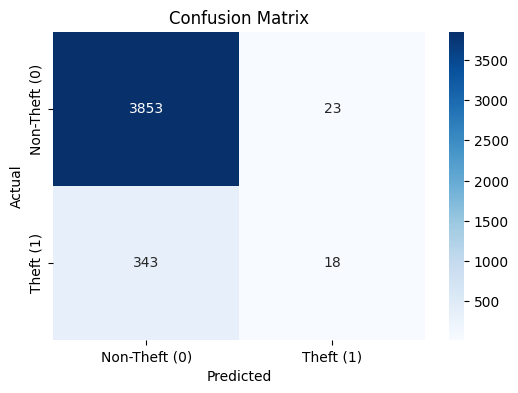

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Theft (0)', 'Theft (1)']

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


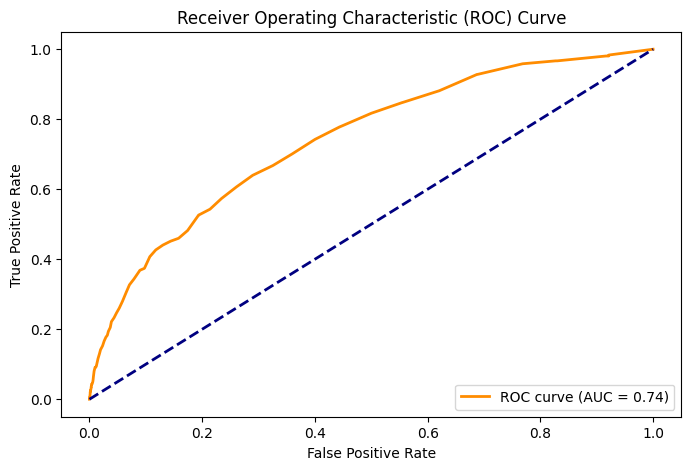

In [42]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
